In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Parametry
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 20

# Wczytanie danych z TFDS
# as_supervised=True -> zwróci tuple (obraz, etykieta)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],  # podział 80/20 dla train/val
    shuffle_files=True,
    as_supervised=True,  # (image, label)
    with_info=True
)

# Funkcja do normalizacji obrazów
def normalize_img(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Przygotowanie datasetów
train_ds = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = ds_val.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Buforowanie i batching
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Nazwy klas
class_names = ds_info.features['label'].names
print("Klasy:", class_names)

Klasy: ['rock', 'paper', 'scissors']


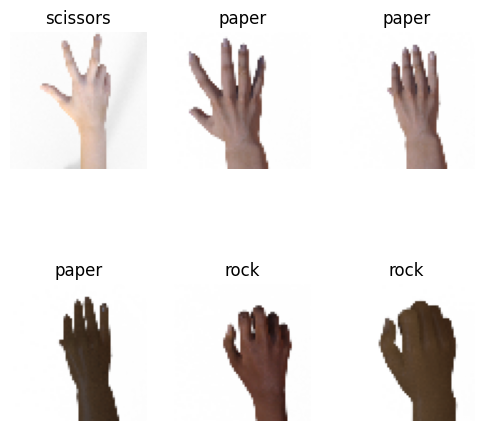

In [8]:
plt.figure(figsize=(6,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [9]:
# Model - Sieć Zwykła
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])


model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,146,755 (12.00 MB)

 Trainable params: 3,146,755 (12.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4697 - loss: 4.7488 - val_accuracy: 0.8393 - val_loss: 0.6453
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7708 - loss: 0.6228 - val_accuracy: 0.8194 - val_loss: 0.5201
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7946 - loss: 0.5365 - val_accuracy: 0.8095 - val_loss: 0.4781
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8467 - loss: 0.4520 - val_accuracy: 0.7857 - val_loss: 0.4774
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8502 - loss: 0.4290 - val_accuracy: 0.9147 - val_loss: 0.3046
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8814 - loss: 0.3704 - val_accuracy: 0.9524 - val_loss: 0.2328
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9425 - loss: 0.2246 - val_accuracy: 0.9365 - val_loss: 0.2621
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9385 - loss: 0.2226 - val_accuracy: 0.9425 - val_los

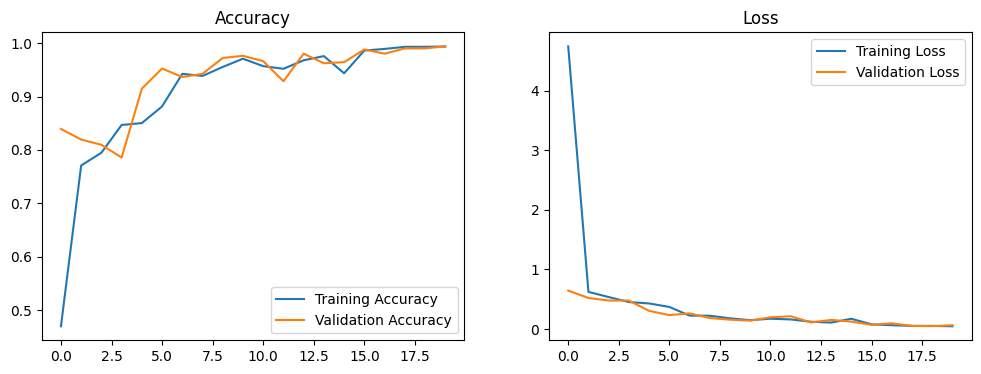

In [10]:
# ============================================
# WYKRESY DOKŁADNOŚCI I STRATY
# ============================================

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()

In [11]:
# Ewaluacja i Zapis modelu

test_loss, test_acc = model.evaluate(test_ds)
print("Dokładność na zbiorze testowym:", test_acc)

model.save("rps_simple_model.keras")
print("Model zapisany jako rps_dense_model.keras")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6022 - loss: 1.7089 
Dokładność na zbiorze testowym: 0.602150559425354
Model zapisany jako rps_dense_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


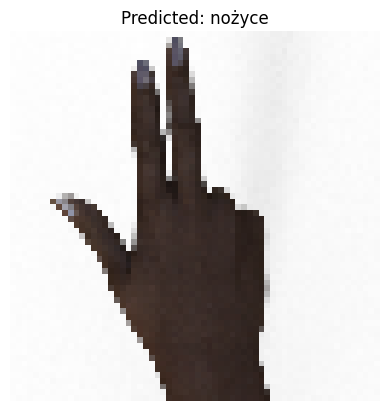

papier: 0.0010
kamień: 0.3562
nożyce: 0.6428


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def predict_and_show(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # dodaj wymiar batch

    img_array_norm = img_array / 255.0

    predictions = model.predict(img_array_norm)
    predicted_class = np.argmax(predictions, axis=1)[0]

    plt.imshow(np.uint8(img_array[0]))
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.show()

    for i, prob in enumerate(predictions[0]):
        print(f"{class_names[i]}: {prob:.4f}")

class_names = ["papier", "kamień", "nożyce"]
imgpath2 = Path("data/rps-test-set/scissors/scissors9.png")
predict_and_show(imgpath2, model, class_names)

